In this notebook I use a pretrained model to identify faces in images. The model is a FaceNet model trained on MS-Celeb-1M dataset, and it is designed to extract faces from the images. Once we have the faces dataset, we use a SVM algorithm to classify the face between the different classes (celebrities).

In [30]:
# Importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
from mtcnn.mtcnn import MTCNN
from PIL import Image
from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from os import listdir
from os.path import isdir
from random import choice

# Preprocessing images
 As the model is expecting faces, we first must preprocess the images. We define different functions for iterate over all the folders and extract the faces from images. The images are in the '5-celebrity-faces-dataset' folder, with train and val sets with the same classes. We use a MTCNN detector to detect the faces in images.

In [31]:
# Function to extract the face from a given image
def Extract_Face(filename, required_size=(160, 160)):
    # load image from file
    image = Image.open(filename)
    # convert to RGB (if needed)
    image = image.convert('RGB')
    # convert to array
    pixels = np.asarray(image)
    # create the dectector
    detector = MTCNN()
    # apply the detector to detect faces in the image
    results = detector.detect_faces(pixels)
    # bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    # select the face
    face = pixels[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

In [32]:
# Function to load images and extract faces from all images in a directory
def load_faces(directory):
    faces = []
    # enumerate files in the directory
    for filename in listdir(directory):
        # path
        path = directory + filename
        # extract the face
        face = Extract_Face(path)
        # store the face
        faces.append(face)
    return faces

In [33]:
# Load each class dataset in a directory
def load_dataset(directory):
    X, y = [], []
    # enumerate folders/classes
    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        # skip any files that might be in the dir
        if not isdir(path):
            continue
        # load all faces in the directory
        faces = load_faces(path)
        # create the labels
        labels = [subdir for _ in range(len(faces))]
        # store faces and labels
        X.extend(faces)
        y.extend(labels)
    return np.asarray(X), np.asarray(y)

In [34]:
# Load train dataset
X_train, y_train = load_dataset('5-celebrity-faces-dataset/train/')
print('Train shape:', X_train.shape, y_train.shape)
# Load test dataset
X_test, y_test = load_dataset('5-celebrity-faces-dataset/val/')
print('Test shape:', X_test.shape, y_test.shape)

Train shape: (93, 160, 160, 3) (93,)
Test shape: (25, 160, 160, 3) (25,)


In [35]:
# Save arrays to one compressed file
np.savez_compressed('5-celebrity-faces-dataset.npz', X_train, y_train, X_test, y_test)

Done. We went throught all the images, both train and test, and extracted the faces. They were finally stored in a compressed file, with their corresponding labels.

# Get the face embeddings
Once the faces got extracted, it's time to get the embeddings from them. Here is were the FaceNet model is useful. It was trained on these images, so it will get great results.

In [37]:
# Load the FaceNet model
model = load_model('facenet_keras.h5')
# Print the model inputs
print(model.inputs)
# Print the model outputs
print(model.outputs)

[<tf.Tensor 'input_1_2:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Identity:0' shape=(None, 128) dtype=float32>]


In [38]:
# Get the face embedding for one face
def get_embedding(model, face_pixels):
    # scale pixels values
    face_pixels = face_pixels.astype('float32')
    # standardize pixel values across channels
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean) / std
    # transform face into one sample
    samples = np.expand_dims(face_pixels, axis=0)
    # make prediction to get embeddig
    y_embed = model.predict(samples)
    return y_embed[0]

In [39]:
# Convert each face in the train dataset to an embedding
X_train_new = []
for face_pixels in X_train:
    # get the embedding from the face
    embedding = get_embedding(model, face_pixels)
    # store
    X_train_new.append(embedding)
# Create an array
X_train_new = np.asarray(X_train_new)
# Print the shape
print(X_train_new.shape)

(93, 128)


In [40]:
# Convert each face in the test dataset to an embedding
X_test_new = []
for face_pixels in X_test:
    # get the embedding from the face
    embedding = get_embedding(model, face_pixels)
    # store
    X_test_new.append(embedding)
# Create an array
X_test_new = np.asarray(X_test_new)
# Print the shape
print(X_test_new.shape)

(25, 128)


In [41]:
# Save the embedding datasets in a compressed file
np.savez_compressed('5-celebrity-faces-embeddings.npz', X_train_new, y_train, X_test_new, y_test)

The embeddings are stored in a compressed file again.

# Fit the SVM model
Once the embeddings are extracted, we must normalize the input vectors and encode the labels (target variables) before fedding them to the SVM model.

In [42]:
# Load the embedding datasets from the compressed file
data = np.load('5-celebrity-faces-embeddings.npz')
X_train, y_train, X_test, y_test = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print(X_train.shape[0], X_test.shape[0])

93 25


In [43]:
# Normalize/scale the input vectors
in_encoder = Normalizer(norm='l2')
X_train = in_encoder.transform(X_train)
X_test = in_encoder.transform(X_test)

In [44]:
# Label encode the target variables
out_encoder = LabelEncoder()
out_encoder.fit(y_train)
y_train = out_encoder.transform(y_train)
y_test = out_encoder.transform(y_test)

In [45]:
# Declare the SVC model
model = SVC(kernel='linear', probability=True)
# Fit the model to the train data
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

# Evaluating on the test set
The SMV model is fitted, and now ready to be applied to some random test images. These test images were preprocessed before, so they can be passed to the model directly.

In [46]:
# Load the test faces dataset
data = np.load('5-celebrity-faces-dataset.npz')
X_test_faces = data['arr_2']

In [47]:
# Select a random example from the test dataset
selection = choice([i for i in range(X_test.shape[0])])
random_face_pixels = X_test_faces[selection]
random_face_emb = X_test[selection]
random_face_class = y_test[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])

In [48]:
# Prediction for the face
samples = np.expand_dims(random_face_emb, axis=0)
y_pred_class = model.predict(samples)
# Probability of correct prediction
y_pred_prob = model.predict_proba(samples)

In [49]:
class_index = y_pred_class[0]
# Get the probability of prediction for the selected image
class_probability = y_pred_prob[0, class_index] * 100
# Transform from integer to label
predict_names = out_encoder.inverse_transform(y_pred_class)

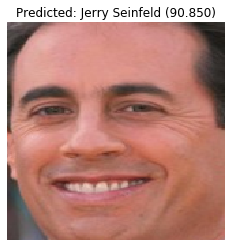

In [50]:
# Show the random image
plt.imshow(random_face_pixels)
# Set the title
title = 'Predicted: %s (%.3f)' % (predict_names[0], class_probability)
plt.title(title)
# Not show axis
plt.axis('off')
plt.show()

The model predicted correctly the image, as expected.